# Sentence Transformer

In [5]:
import pandas as pd
import json
import re
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

# Load NLTK stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Load JSON data
with open('../data/processed/UN_data.json', 'r') as file:
    data = json.load(file)

# Convert JSON data to DataFrame
articles = pd.DataFrame(data)

def preprocess_text(text):
    text = re.sub('[,\.!?]', '', text)
    text = text.lower()
    return text

articles['text_processed'] = articles['text'].apply(preprocess_text)

# Tokenize and remove stopwords
def remove_stopwords(texts):
    return [" ".join([word for word in re.findall(r'\b\w+\b', doc) if word not in stop_words]) for doc in texts]

data = articles['text_processed'].values.tolist()
data_processed = remove_stopwords(data)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritutoshniwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


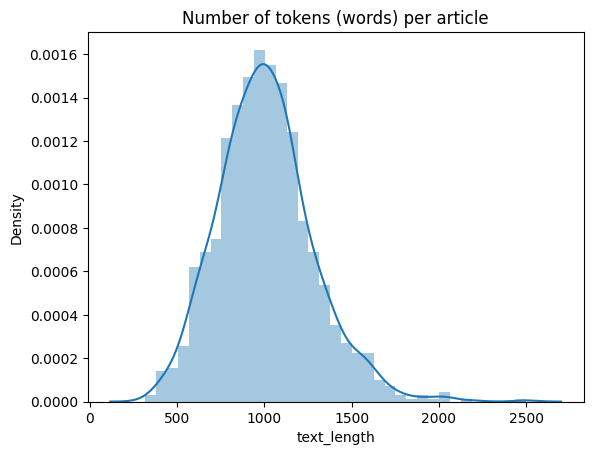

In [6]:
#visualise the length of the articles in data processed
articles['text_processed'] = data_processed
articles['text_length'] = articles['text_processed'].apply(lambda x: len(x.split()))

import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(articles['text_length'])
plt.title('Number of tokens (words) per article')
plt.show();

In [9]:
articles.head()

,session,year,country,text,label,text_processed,text_length
0,57,2002,PAN,﻿Allow me\nto begin my statement by expressing...,135,allow begin statement expressing pleasure gove...,595
1,57,2002,IND,﻿I\ncongratulate Mr. Kavan on his election as ...,77,congratulate mr kavan election president gener...,805
2,57,2002,MDV,"﻿Mr. President, it gives\nme great pleasure to...",110,mr president gives great pleasure join others ...,831
3,57,2002,DJI,﻿In a year\nof frightful tragedy and uncertain...,45,year frightful tragedy uncertainty least fortu...,1151
4,57,2002,NLD,"﻿The smoke\nat ground zero, only a few blocks ...",128,smoke ground zero blocks away cleared empty sp...,818


In [10]:
# countries with coalition of the willing
coalition_of_willing_countries_list = ["United States",
    "Afghanistan", "Albania", "Australia", "Azerbaijan", "Bulgaria", "Colombia",
    "Czechia", "Denmark", "El Salvador", "Eritrea", "Estonia", "Ethiopia",
    "Georgia", "Hungary", "Iceland", "Italy", "Japan", "Korea, Republic of", "Latvia",
    "Lithuania", "North Macedonia", "Netherlands", "Nicaragua", "Philippines", "Poland",
    "Romania", "Slovakia", "Spain", "Türkiye", "United Kingdom", "Uzbekistan",
    "Costa Rica", "Dominican Republic", "Honduras", "Kuwait", "Marshall Islands",
    "Micronesia, Federated States of", "Mongolia", "Palau", "Portugal", "Rwanda", "Singapore",
    "Solomon Islands", "Uganda", "Panama", "Angola", "Tonga", "Ukraine"
]
#get countries from the data
import pycountry
countries = articles['country'].unique()
country_names = {country.alpha_3: country.name for country in pycountry.countries}
#add country names to the data
articles['country_name'] = articles['country'].map(country_names)

articles.head()

,session,year,country,text,label,text_processed,text_length,country_name
0,57,2002,PAN,﻿Allow me\nto begin my statement by expressing...,135,allow begin statement expressing pleasure gove...,595,Panama
1,57,2002,IND,﻿I\ncongratulate Mr. Kavan on his election as ...,77,congratulate mr kavan election president gener...,805,India
2,57,2002,MDV,"﻿Mr. President, it gives\nme great pleasure to...",110,mr president gives great pleasure join others ...,831,Maldives
3,57,2002,DJI,﻿In a year\nof frightful tragedy and uncertain...,45,year frightful tragedy uncertainty least fortu...,1151,Djibouti
4,57,2002,NLD,"﻿The smoke\nat ground zero, only a few blocks ...",128,smoke ground zero blocks away cleared empty sp...,818,Netherlands


In [11]:
#add column called coalition_of_willing, if the country is in the list, then it is part of the coalition
articles['coalition_of_willing'] = articles['country_name'].isin(coalition_of_willing_countries_list)
articles.head()
# Replace coalition_of_willing with 1 and 0
articles['coalition_of_willing'] = articles['coalition_of_willing'].astype(int)
articles.head()

,session,year,country,text,label,text_processed,text_length,country_name,coalition_of_willing
0,57,2002,PAN,﻿Allow me\nto begin my statement by expressing...,135,allow begin statement expressing pleasure gove...,595,Panama,1
1,57,2002,IND,﻿I\ncongratulate Mr. Kavan on his election as ...,77,congratulate mr kavan election president gener...,805,India,0
2,57,2002,MDV,"﻿Mr. President, it gives\nme great pleasure to...",110,mr president gives great pleasure join others ...,831,Maldives,0
3,57,2002,DJI,﻿In a year\nof frightful tragedy and uncertain...,45,year frightful tragedy uncertainty least fortu...,1151,Djibouti,0
4,57,2002,NLD,"﻿The smoke\nat ground zero, only a few blocks ...",128,smoke ground zero blocks away cleared empty sp...,818,Netherlands,1


In [8]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Initialize the BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(data_processed, show_progress_bar=True)

Batches: 100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


In [12]:
y = articles['coalition_of_willing']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42, stratify=y)

# Train the classifier
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.706140350877193
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       169
           1       0.46      0.80      0.58        59

    accuracy                           0.71       228
   macro avg       0.68      0.74      0.68       228
weighted avg       0.79      0.71      0.72       228



In [16]:
import umap

# Reduce to 2D or 5D for visualization and clustering
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine', 
                            random_state=42).fit_transform(embeddings)
print(f"UMAP embeddings shape: {umap_embeddings.shape}")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP embeddings shape: (1138, 5)


In [17]:
from sklearn.cluster import KMeans

num_clusters = 2

# Cluster with KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
# Using KMeans labels (if you used KMeans)
articles['cluster'] = kmeans_labels

In [19]:
import pandas as pd

# Group by 'cluster' and count 'coalition_of_willing'
cluster_label_counts = articles.groupby('cluster')['coalition_of_willing'].value_counts().unstack(fill_value=0)

# Rename columns for clarity
cluster_label_counts.columns = [0, 1]

print(cluster_label_counts)

           0    1
cluster          
0        267   39
1        578  254


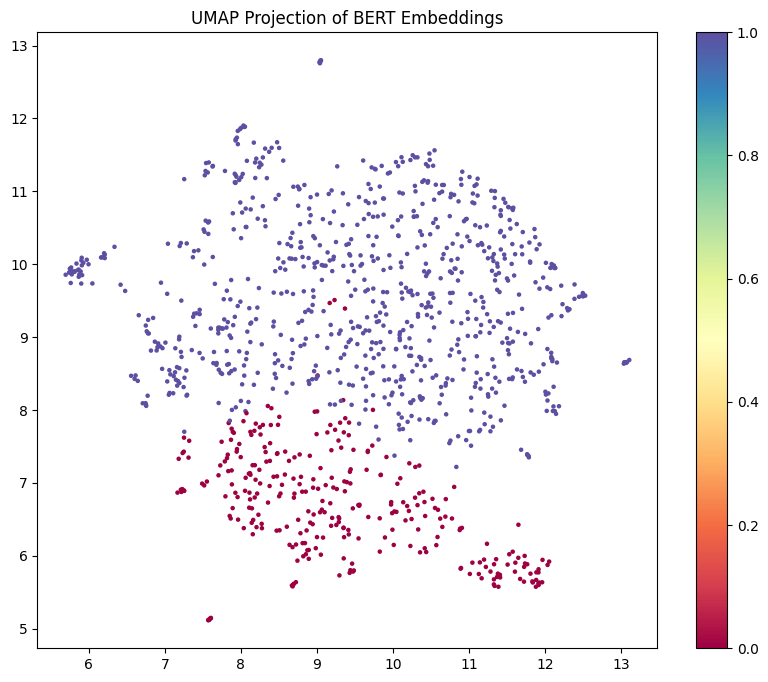

In [20]:
import matplotlib.pyplot as plt

# If UMAP embeddings are 2D, you can plot them directly
umap_2d = umap.UMAP(n_neighbors=15, 
                    n_components=2, 
                    metric='cosine', 
                    random_state=42).fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=kmeans_labels, cmap='Spectral', s=5)
plt.colorbar()
plt.title('UMAP Projection of BERT Embeddings')
plt.show()

Cluster 0


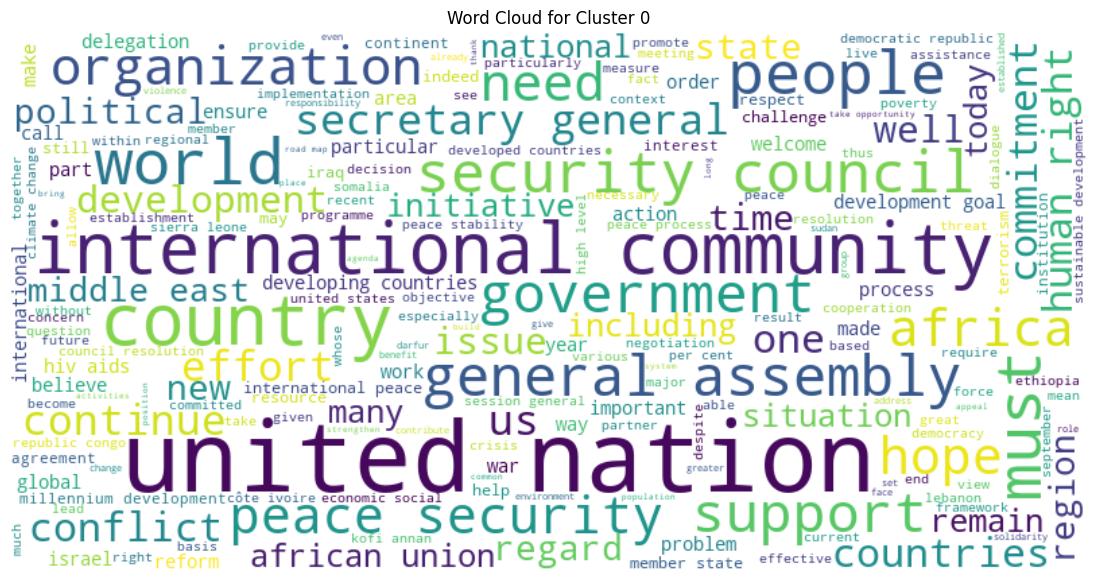

Cluster 1


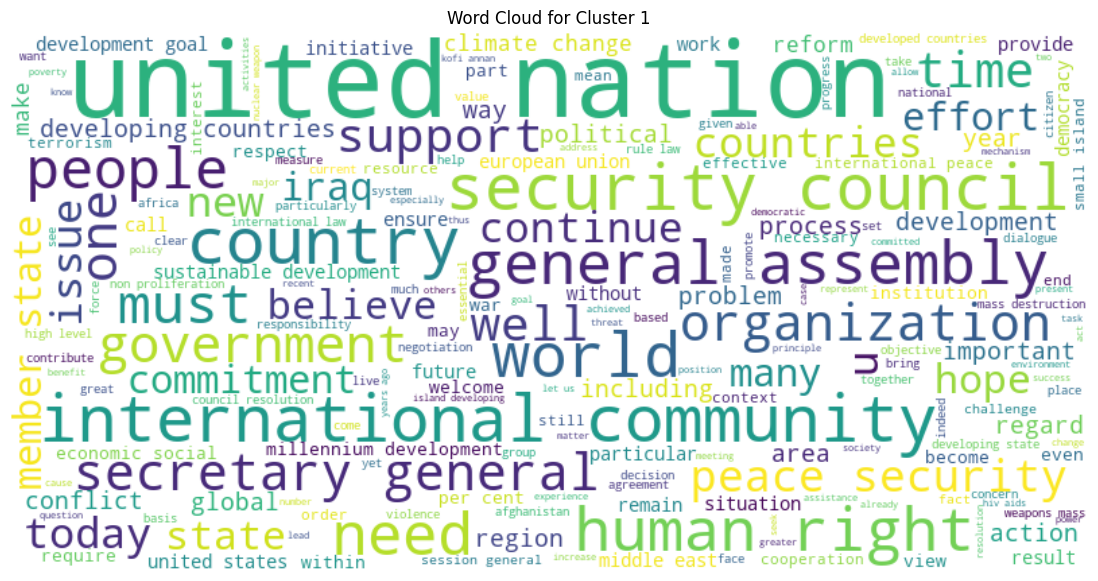

In [21]:
from wordcloud import WordCloud

def plot_word_cloud(cluster_number):
    cluster_docs = articles[articles['cluster'] == cluster_number]['text_processed']
    text = ' '.join(cluster_docs)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_number}')
    plt.show()

# Plot word clouds for each cluster
for cluster_num in set(kmeans_labels):
        print(f'Cluster {cluster_num}')
        plot_word_cloud(cluster_num)